# **태양광 발전량 예측 AI 경진대회** - 데이콘

https://dacon.io/competitions/official/235680/overview/description

[주제]

 * 예시로 제시된 지역의 기상 데이터와 과거 발전량 데이터를 활용하여, 시간대별 태양광 발전량을 예측

* 기대효과 : 시간대별 소비자 그룹의 전력소비량 예측 데이터와 결합하여 가장 효율적인 시간대별 태양광 발전과 국가 전력망을 조합 가능. 각 소비자 그룹에 최적화된 공급계획 수립 가능.

[배경]

* 신재생 에너지 태양광 발전량 예측을 위한 시계열 데이터 분석기법 발굴
* 신재생 에너지 관리 솔루션 개발 활용 및 에너지 서비스 산업 발전 촉진

[대회 설명]

모델은 7일(Day0 ~ Day6) 동안의 데이터를 인풋으로 활용하여, 향후 2일(Day7 ~ Day8) 동안의 30분 간격의 발전량(TARGET)을 예측해야 한다.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-데이터-불러오기" data-toc-modified-id="1.-데이터-불러오기-1"><span class="toc-item-num">1&nbsp;&nbsp;</span><strong>1. 데이터 불러오기</strong></a></span><ul class="toc-item"><li><span><a href="#train-파일-불러오기" data-toc-modified-id="train-파일-불러오기-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span><strong>train 파일 불러오기</strong></a></span></li><li><span><a href="#train-데이터셋" data-toc-modified-id="train-데이터셋-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span><strong>train 데이터셋</strong></a></span></li></ul></li><li><span><a href="#정규화-처리" data-toc-modified-id="정규화-처리-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>정규화 처리</a></span></li><li><span><a href="#슬라이딩-윈도우" data-toc-modified-id="슬라이딩-윈도우-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>슬라이딩 윈도우</a></span></li><li><span><a href="#변수-선택" data-toc-modified-id="변수-선택-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>변수 선택</a></span><ul class="toc-item"><li><span><a href="#다중공선성" data-toc-modified-id="다중공선성-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>다중공선성</a></span></li><li><span><a href="#회귀분석---변수선택법,-최소제곱추정법" data-toc-modified-id="회귀분석---변수선택법,-최소제곱추정법-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>회귀분석 - 변수선택법, 최소제곱추정법</a></span></li></ul></li><li><span><a href="#Train,-Test-set-나누기" data-toc-modified-id="Train,-Test-set-나누기-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train, Test set 나누기</a></span></li><li><span><a href="#LSTM-모델" data-toc-modified-id="LSTM-모델-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>LSTM 모델</a></span><ul class="toc-item"><li><span><a href="#예측-모델의-활성화-함수---relu-적용" data-toc-modified-id="예측-모델의-활성화-함수---relu-적용-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>예측 모델의 활성화 함수 - relu 적용</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau

import math

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

## **1. 데이터 불러오기**

### **train 파일 불러오기**

In [2]:
train = pd.read_csv('data/train/train.csv')
train.tail()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
52555,1094,21,30,0,0,2.4,70.70,-4,0.0
52556,1094,22,0,0,0,2.4,66.79,-4,0.0
52557,1094,22,30,0,0,2.2,66.78,-4,0.0
52558,1094,23,0,0,0,2.1,67.72,-4,0.0
52559,1094,23,30,0,0,2.1,67.70,-4,0.0


**컬럼 설명**

* Hour : 시간
* Minute : 분
* DHI : 수평면 산란일사량
* DNI : 직달일사량
* WS : 풍속
* RH : 상대습도
* T : 온도
* TARGET : 태양광 발전량

### **train 데이터셋**

**결측치 확인**

In [3]:
train.isnull().sum()

Day       0
Hour      0
Minute    0
DHI       0
DNI       0
WS        0
RH        0
T         0
TARGET    0
dtype: int64

**데이터 분포 확인**

In [4]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Day,52560.0,547.000000,316.102148,0.00,273.0000,547.0,821.00000,1094.000000
Hour,52560.0,11.500000,6.922252,0.00,5.7500,11.5,17.25000,23.000000
Minute,52560.0,15.000000,15.000143,0.00,0.0000,15.0,30.00000,30.000000
DHI,52560.0,64.344121,103.897125,0.00,0.0000,0.0,87.00000,528.000000
DNI,52560.0,234.792371,349.684583,0.00,0.0000,0.0,469.00000,1059.000000
WS,52560.0,2.456033,1.426874,0.00,1.4000,2.2,3.20000,12.000000
RH,52560.0,56.793102,22.052875,7.59,39.6975,57.6,72.77000,100.000000
T,52560.0,9.279928,10.179741,-19.00,1.0000,9.0,17.00000,35.000000
TARGET,52560.0,17.790630,25.759955,0.00,0.0000,0.0,32.08989,99.913939


In [5]:
train.corr()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
Day,1.000000,0.000000,0.000000,-0.027802,0.021901,0.038477,-0.127688,0.072897,-0.002505
Hour,0.000000,1.000000,0.000000,0.029905,-0.018094,-0.055903,-0.084275,0.105528,0.003817
Minute,0.000000,0.000000,1.000000,-0.001305,-0.000997,-0.009522,0.008839,-0.007646,-0.000240
DHI,-0.027802,0.029905,-0.001305,1.000000,0.288294,0.203286,-0.478503,0.457813,0.666908
DNI,0.021901,-0.018094,-0.000997,0.288294,1.000000,0.219555,-0.611184,0.402460,0.833547
WS,0.038477,-0.055903,-0.009522,0.203286,0.219555,1.000000,-0.230035,0.027693,0.238521
RH,-0.127688,-0.084275,0.008839,-0.478503,-0.611184,-0.230035,1.000000,-0.532777,-0.677178
T,0.072897,0.105528,-0.007646,0.457813,0.402460,0.027693,-0.532777,1.000000,0.561990
TARGET,-0.002505,0.003817,-0.000240,0.666908,0.833547,0.238521,-0.677178,0.561990,1.000000


TARGET에 영향을 많이 주는 순서 : DNI, DHI, RH, T, WS, HOUR, DAY, MINUTE

# **2. EDA**

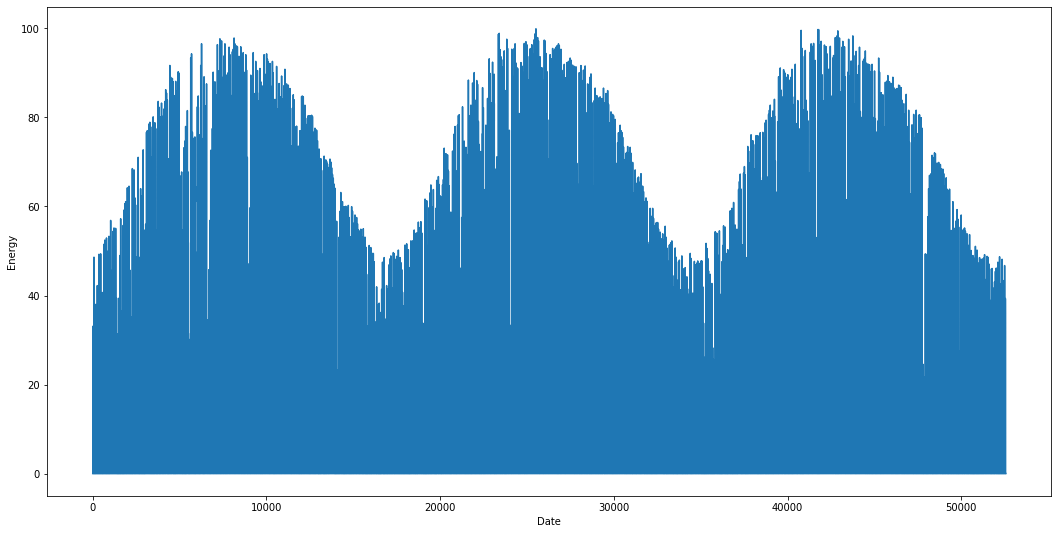

In [7]:
plt.figure(figsize=(18, 9))
df = train.copy()
plt.plot(df.index, df['TARGET'])
plt.xlabel('Date', fontsize=10)
plt.ylabel('Energy')
plt.show()

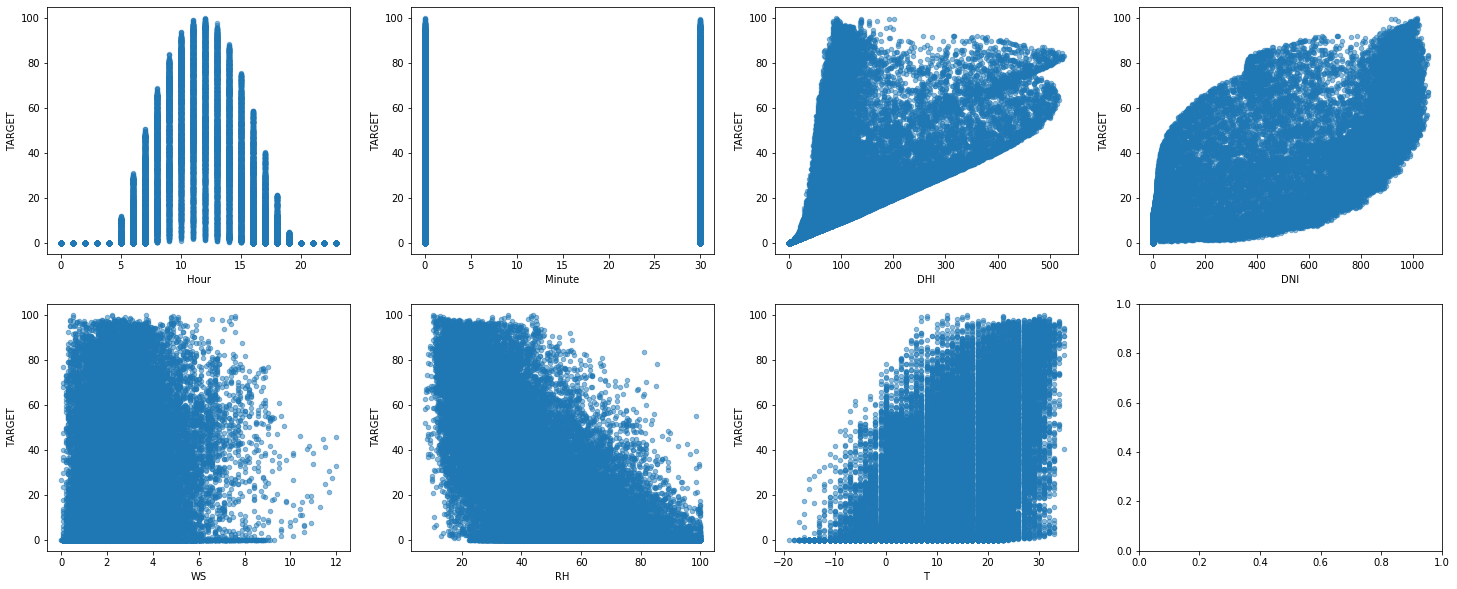

In [8]:
fig, axes = plt.subplots(2, 4, figsize=(25, 10))

train.plot(x='Hour', y='TARGET', kind='scatter', alpha=0.5, ax=axes[0, 0])
train.plot(x='Minute', y='TARGET', kind='scatter', alpha=0.5, ax=axes[0, 1])
train.plot(x='DHI', y='TARGET', kind='scatter', alpha=0.5, ax=axes[0, 2])
train.plot(x='DNI', y='TARGET', kind='scatter', alpha=0.5, ax=axes[0, 3])
train.plot(x='WS', y='TARGET', kind='scatter', alpha=0.5, ax=axes[1, 0])
train.plot(x='RH', y='TARGET', kind='scatter', alpha=0.5, ax=axes[1, 1])
train.plot(x='T', y='TARGET', kind='scatter', alpha=0.5, ax=axes[1, 2])

plt.show()

# **3. 데이터 전처리**

## 정규화 처리

In [4]:
data = train.loc[:, ['DHI', 'DNI', 'WS', 'RH', 'T']]
target = train.loc[:, ['TARGET']]

In [5]:
sc = MinMaxScaler()

test_data = sc.fit_transform(data)
target_data = sc.fit_transform(target)

In [6]:
# 정규화 결과 확인
data = pd.DataFrame(test_data,columns=['DHI', 'DNI', 'WS', 'RH', 'T'])
data.head()

,DHI,DNI,WS,RH,T
0,0.0,0.0,0.125000,0.665404,0.12963
1,0.0,0.0,0.125000,0.665188,0.12963
2,0.0,0.0,0.133333,0.694622,0.12963
3,0.0,0.0,0.133333,0.694297,0.12963
4,0.0,0.0,0.133333,0.731631,0.12963


In [7]:
target = pd.DataFrame(target_data, columns=['TARGET'])
target.tail()

,TARGET
52555,0.0
52556,0.0
52557,0.0
52558,0.0
52559,0.0


## 슬라이딩 윈도우

In [8]:
# 과거 7일의 데이터로 미래 2일 예측

def sliding_window(data, target, window_size):
    data_list = []
    target_list = []
    
    for i in range(len(data) - window_size-96):
        data_list.append(np.array(data.iloc[i : i+window_size]))
        target_list.append(np.array(target.iloc[i+window_size : i+window_size+96]))
    
    return np.array(data_list), np.array(target_list)

In [9]:
# 하루 48개* 7일 = 336
data_ar, target_ar = sliding_window(data, target, 336)

## 변수 선택

독립변수를 결정하기 위해 다중공선성 확인 및 회귀분석의 최소제곱추정법 확인

### 다중공선성

**독립변수 간 상관관계를 보이는 것**

독립변수들은 종속변수하고만 상관관계가 있어야 선형적인 관계가 있다. 하지만 독립변수들 사이에 상관관계가 있으면 부정적인 결과가 도출될 수 있다. 

VIF 수치가 10 이상 혹은 상관계수 값이 0.8이상이면 다중공선성이 있다고 판단.

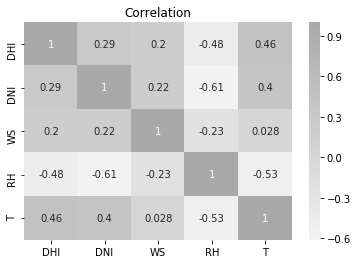

In [10]:
import seaborn as sns

data.corr()  
cmap = sns.light_palette('darkgray', as_cmap=True)
sns.heatmap(data.corr(), annot=True, cmap=cmap)
plt.title("Correlation")
plt.show()

In [3]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['Features'] = data.columns
vif['VIF Factor'] = [variance_inflation_factor(data.values, i)
                    for i in range(data.shape[1])]
vif

,Features,VIF Factor
0,Day,3.551929
1,Hour,3.403173
2,Minute,1.952729
3,DHI,4.384161
4,DNI,8.326899
5,WS,3.858941
6,RH,4.665722
7,T,2.795753
8,TARGET,14.802360


VIF 수치가 모두 10 이하, 상관계수 값이 0.8 이하로 다중공선성이 없다고 판단.

### 회귀분석 - 변수선택법, 최소제곱추정법

**각 변수가 종속변수인 Target 변수에 유의미한 것이 있는지 확인**

결정계수를 통해 회귀선형모형이 얼마나 오차가 적고 정확도가 높은지 판단. (0에 가까울수록 회귀식의 정확도 낮고, 1에 가까울 수록 정확도 높음)

유의확률이 유의수준보다 작으면 '통계적으로 유의미하다'라고 표현. (유의수준 0.05)

In [30]:
import statsmodels.api as sm

lm = sm.OLS(target, data)
result = lm.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 TARGET   R-squared (uncentered):                   0.931
Model:                            OLS   Adj. R-squared (uncentered):              0.931
Method:                 Least Squares   F-statistic:                          1.428e+05
Date:                Tue, 18 May 2021   Prob (F-statistic):                        0.00
Time:                        22:47:03   Log-Likelihood:                          56849.
No. Observations:               52560   AIC:                                 -1.137e+05
Df Residuals:                   52555   BIC:                                 -1.136e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
DHI            0.5536      0.002    254.294      0.000       0.549       0.558
DNI            0.5072      0.001    379.776      0.000       0.505       0.510
WS            -0.0335      0.003    -11.546      0.000      -0.039      -0.028
RH            -0.0674      0.001    -53.323      0.000      -0.070      -0.065
T              0.0808      0.002     47.795      0.000       0.077       0.084
==============================================================================
Omnibus:                     6211.597   Durbin-Watson:                   0.312
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29641.663
Skew:                           0.489   Prob(JB):                         0.00
Kurtosis:                       6.546   Cond. No.                         7.07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

결정계수 0.931이고, 독립변수들의 유의확률이 유의수준 0.05보다 작으므로 회귀모형이 통계적으로 유의하다고 판단.

In [12]:
from IPython.core.interactiveshell import InteractiveShell
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def linear_reg(x, y):
    model = LinearRegression(fit_intercept = True)  # 단순선형회귀
    model.fit(x, y)
    RSS = mean_squared_error(y, model.predict(x)) * len(y)
    R_squared = model.score(x, y)
    return RSS, R_squared

In [13]:
m = len(data)
k = 8
RSS_list, R_squared_list, feature_list = [], [], []
numb_features = []

In [14]:
# 다섯가지 독립변수들의 모든 조합에 대한 성능 테스트(RSS, R_squared)

import itertools

for k in range(1, len(data.columns) + 1):
    for combo in itertools.combinations(data.columns, k):
        tmp_result = linear_reg(data[list(combo)], data)
        RSS_list.append(tmp_result[0])
        R_squared_list.append(tmp_result[1])
        feature_list.append(combo)
        numb_features.append(len(combo))

C:\spyder\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
C:\spyder\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_averag

In [15]:
df = pd.DataFrame({'numb_features' : numb_features, 'RSS' : RSS_list,
                  'R_squared' : R_squared_list, 'features' : feature_list})
print(df)

    numb_features           RSS  R_squared               features
0               1  1.950206e+03   0.270676                 (DHI,)
1               1  1.202729e+03   0.550212                 (DNI,)
2               1  2.421336e+03   0.094487                  (WS,)
3               1  1.440117e+03   0.461436                  (RH,)
4               1  1.859436e+03   0.304622                   (T,)
5               2  7.190989e+02   0.731077             (DHI, DNI)
6               2  1.764083e+03   0.340281              (DHI, WS)
7               2  1.104647e+03   0.586892              (DHI, RH)
8               2  1.473515e+03   0.448946               (DHI, T)
9               2  1.045667e+03   0.608949              (DNI, WS)
10              2  7.171009e+02   0.731824              (DNI, RH)
11              2  7.735259e+02   0.710722               (DNI, T)
12              2  1.284529e+03   0.519621               (WS, RH)
13              2  1.618542e+03   0.394709                (WS, T)
14        

In [51]:
for i in range(len(R_squared_list)):
    if R_squared_list[i] == max(R_squared_list):
        print('변수 중요도가 높은 값 : ', feature_list[i])
for j in range(len(RSS_list)):
    if RSS_list[j] == max(RSS_list):
        print('오차가 큰 변수 : ', feature_list[j])
        
InteractiveShell.ast_node_interactivity = "all"

변수 중요도가 높은 값 :  ('DHI', 'DNI', 'WS', 'RH', 'T')
오차가 큰 변수 :  ('WS',)


# **4. 모델링**

## Train, Test set 나누기

In [16]:
x_train, x_test, y_train, y_test = train_test_split(data_ar, 
                                                    target_ar, 
                                                    test_size=0.2)

## LSTM 모델

### 예측 모델의 활성화 함수 - relu 적용

In [60]:
model = Sequential()
model.add(LSTM(48, activation='tanh', input_shape=(336, 5)))
model.add(Dense(96, activation='relu'))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 48)                10368     
_________________________________________________________________
dense_1 (Dense)              (None, 96)                4704      
Total params: 15,072
Trainable params: 15,072
Non-trainable params: 0
_________________________________________________________________


In [61]:
history = model.fit(x_train, y_train, 
                    batch_size=256, epochs=16, 
                    validation_data=(x_test, y_test))

Epoch 1/16
163/163 [==============================] - 81s 487ms/step - loss: 0.0567 - val_loss: 0.0195
Epoch 2/16
163/163 [==============================] - 77s 474ms/step - loss: 0.0185 - val_loss: 0.0163
Epoch 3/16
163/163 [==============================] - 78s 477ms/step - loss: 0.0164 - val_loss: 0.0142
Epoch 4/16
163/163 [==============================] - 78s 481ms/step - loss: 0.0142 - val_loss: 0.0137
Epoch 5/16
163/163 [==============================] - 79s 488ms/step - loss: 0.0139 - val_loss: 0.0137
Epoch 6/16
163/163 [==============================] - 79s 483ms/step - loss: 0.0138 - val_loss: 0.0135
Epoch 7/16
163/163 [==============================] - 83s 512ms/step - loss: 0.0137 - val_loss: 0.0135
Epoch 8/16
163/163 [==============================] - 79s 484ms/step - loss: 0.0136 - val_loss: 0.0124
Epoch 9/16
163/163 [==============================] - 80s 490ms/step - loss: 0.0127 - val_loss: 0.0126
Epoch 10/16
163/163 [==============================] - 79s 483ms/step - l

Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

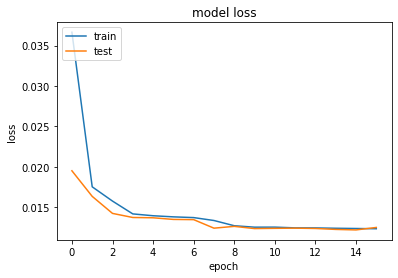

In [62]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# **5. 예측 결과**

In [76]:
predictions = model.predict(x_test) # 예측 값
predict = sc.inverse_transform(predictions) # 정규화한 것을 실제 값으로 변환

<Figure size 1296x648 with 0 Axes>

C:\spyder\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Unrecognized location 'low'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  after removing the cwd from sys.path.


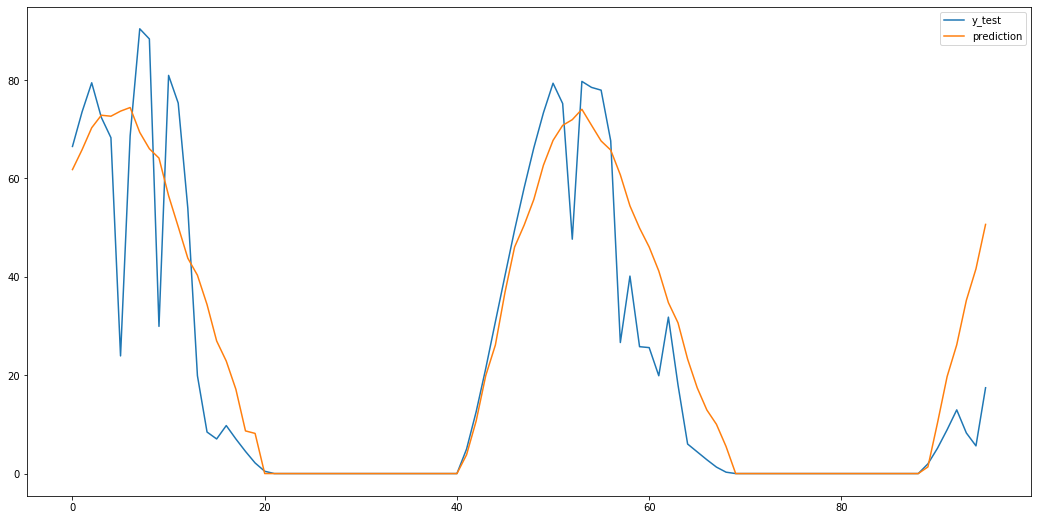

In [85]:
plt.figure(figsize=(18, 9))
plt.plot(sc.inverse_transform(y_test[0]))
plt.plot(predict[0])
plt.legend(['y_test', 'prediction'], loc='low')

<Figure size 1296x648 with 0 Axes>

C:\spyder\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Unrecognized location 'low'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  after removing the cwd from sys.path.


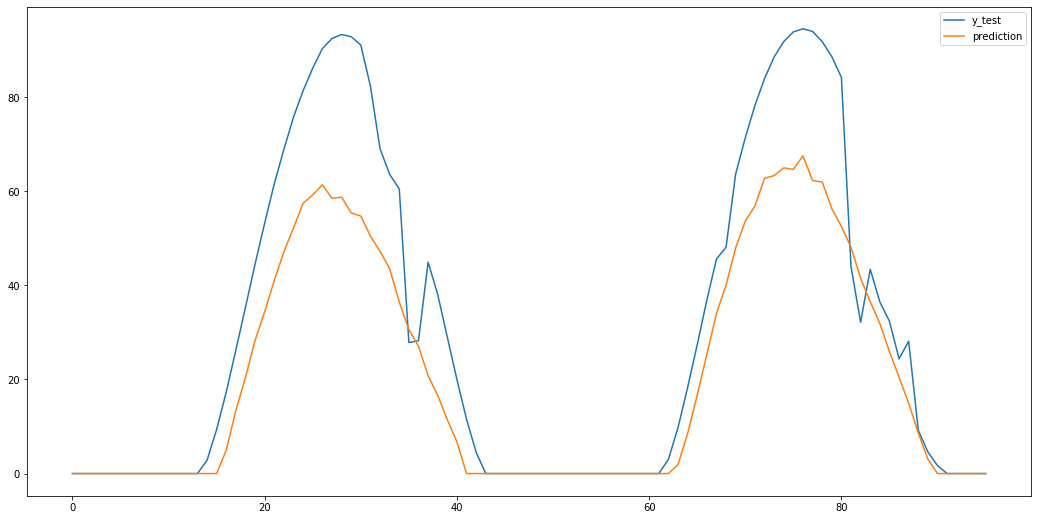

In [89]:
plt.figure(figsize=(18, 9))
plt.plot(sc.inverse_transform(y_test[5000]))
plt.plot(predict[5000])
plt.legend(['y_test', 'prediction'], loc='low')